# Speeches
xxx

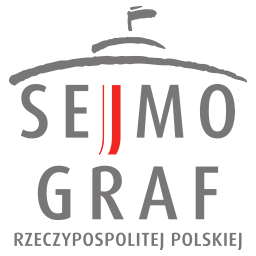


# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/SEJMograf /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/SEJMograf': File exists
/content/gdrive/My Drive/Colab Notebooks/SEJMograf


## Libraries & functions
Let's now install missing libraries and import the necessary libraries and functions we're gonna use in this notebook.

- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `plotly` - visualization

In [4]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import timeit
from bs4 import BeautifulSoup
import regex as re
import requests
from nltk.probability import FreqDist
from datetime import datetime
import tqdm as tq

# Load deputy data

In [5]:
df = pd.read_csv('df_clean.csv', index_col=0)
df.head()

,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33,coworker_33_function,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,

## Add `id` column

In [9]:
# df['id'] = df['profile_url'].apply(lambda x: re.search(r'\d{3}', x).group(0))
# df.head()

,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33_function,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info,id
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,001
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,002
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,003
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,Fal

# Fetch speeches

## Single deputy speeches

In [10]:
def deputySpeeches(deputy_id):

  # initiate the containers
  speeches_pages = []
  speeches = []

  def extractSpeechInfo(element):
    if len(element) > 0:
      content = element.contents[0]
    else: 
      content = element.string
    
    return content

  for page_number in range(1, 100):    

    # perform a http request
    url = f'https://www.sejm.gov.pl/Sejm9.nsf/wypowiedzi.xsp?page={page_number}&id={deputy_id}&symbol=WYPOWIEDZI_POSLA&type=P'
    response = requests.get(url)

    # initiate BeautifulSoup and find objects of our interest
    soup = BeautifulSoup(response.content, 'html.parser')
    rows = soup.find('table', attrs={'class': 'lista-wyp'}).find_all('tr')[1:]

    if len(rows) > 0:
      for row in rows:
        output = [extractSpeechInfo(pos) for pos in row.find_all('td')]
        if output in speeches:
          break
        else:
          speeches.append(output)
    else: break

  df_speeches = pd.DataFrame(
      speeches,
      columns=[
               'posiedzenie',
               'dzień',
               'data',
               'numer',
               'tytuł',
               'retransmisja'
               ]
               )
  def extractText(url):

    # perform a http request
    response = requests.get(url)

    # initiate BeautifulSoup and find objects of our interest
    soup = BeautifulSoup(response.content, 'html.parser')
    elements = soup.find('div', attrs={'class': 'stenogram'}).find_all('p')[1:]

    # extract plain text of the speech
    text = ''.join([e.contents[0] for e in elements])
    text = re.sub('\s+', ' ', text).strip()

    return text

  df_speeches['deputy_id'] = deputy_id
  df_speeches['posiedzenie'] = df_speeches['posiedzenie'].astype('int64')
  df_speeches['dzień'] = df_speeches['dzień'].astype('int64')
  df_speeches['data'] = df_speeches['data'].apply(lambda x: datetime.strptime(str(x), '%d-%m-%Y'))
  df_speeches['wypowiedź_tytuł'] = df_speeches['tytuł'].apply(lambda x: x.string)
  df_speeches['wypowiedź_link'] = df_speeches['tytuł'].apply(lambda x: f'https://www.sejm.gov.pl/Sejm9.nsf/{x.get("href")}')
  df_speeches['wypowiedź_treść'] = df_speeches['wypowiedź_link'].apply(lambda x: extractText(x))
  df_speeches['retransmisja_link'] = df_speeches['retransmisja'].apply(lambda x: f'https://www.sejm.gov.pl/Sejm9.nsf/{x.get("href")}')
  df_speeches.drop(columns=['numer', 'tytuł', 'retransmisja'], inplace=True)

  return df_speeches

In [11]:
df_kaczynski = deputySpeeches('442')

## Party deputies speeches

In [ ]:
def partySpeeches(party):
  ids = df[df['election_list'] == party]['id']
  speeches = pd.concat([deputySpeeches(id) for id in tq.tqdm(ids)])
  return speeches

In [ ]:
# speeches_sld = partySpeeches('Sojusz Lewicy Demokratycznej')

# Language processing

## Lemmatization & frequency distribution

In [ ]:
!pip install -U spacy
!python -m spacy download pl_core_news_sm

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.3)
2021-03-02 08:33:12.539874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [ ]:
import spacy
from spacy.lang.pl.examples import sentences 

nlp = spacy.load('pl_core_news_sm')
doc = nlp(' '.join(df_kaczynski['wypowiedź_treść'].tolist()))

tokens_lemma = []
for t in doc:
  if t.is_stop == False and t.is_punct == False:
    tokens_lemma.append(t.lemma_)

fdist = FreqDist(tokens_lemma)
fdist.most_common(100)

[('państwo', 113),
 ('pani', 70),
 ('ustawa', 66),
 ('mówić', 65),
 ('premiera', 56),
 ('minister', 55),
 ('oklaski', 51),
 ('praca', 50),
 ('poseł', 49),
 ('rząd', 46),
 ('pieniądz', 45),
 ('rok', 43),
 ('prosty', 43),
 ('chcieć', 42),
 ('powiedzieć', 40),
 ('człowiek', 40),
 ('lewica', 40),
 ('polski', 38),
 ('Polska', 37),
 ('pracownik', 35),
 ('prosić', 33),
 ('naprawdę', 32),
 ('mieć', 32),
 ('czas', 31),
 ('publiczny', 29),
 ('dziękować', 28),
 ('pytanie', 28),
 ('firma', 25),
 ('pomoc', 25),
 ('sala', 25),
 ('kolejny', 24),
 ('sprawa', 24),
 ('poprawka', 23),
 ('podatek', 23),
 ('prawo', 23),
 ('zrobić', 21),
 ('niestety', 21),
 ('Wysok', 20),
 ('izbo', 20),
 ('pensja', 20),
 ('zasiłek', 20),
 ('płaca', 19),
 ('zwolnienie', 19),
 ('problem', 19),
 ('słowo', 19),
 ('wiedzieć', 18),
 ('lud', 18),
 ('robić', 18),
 ('projekt', 18),
 ('miesiąc', 17),
 ('pan', 17),
 ('wielki', 17),
 ('oczywiście', 17),
 ('dzwonko', 17),
 ('sam', 17),
 ('wasz', 17),
 ('działać', 16),
 ('usłyszeć', 16),

# polBERT

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 1.9MB 5.6MB/s 
     |████████████████████████████████| 890kB 18.1MB/s 
     |████████████████████████████████| 3.2MB 23.7MB/s 


In [ ]:
from transformers import *

In [ ]:
model = BertForMaskedLM.from_pretrained("dkleczek/bert-base-polish-cased-v1")
tokenizer = BertTokenizer.from_pretrained("dkleczek/bert-base-polish-cased-v1")
nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at dkleczek/bert-base-polish-cased-v1 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for pred in nlp(f'Najpopularniejszym {nlp.tokenizer.mask_token} w Rumunii jest Dacia.'):
  print(pred)

{'sequence': 'Najpopularniejszym miastem w Rumunii jest Dacia.', 'score': 0.6278373003005981, 'token': 12364, 'token_str': 'm i a s t e m'}
{'sequence': 'Najpopularniejszym klubem w Rumunii jest Dacia.', 'score': 0.09118784219026566, 'token': 20825, 'token_str': 'k l u b e m'}
{'sequence': 'Najpopularniejszym krajem w Rumunii jest Dacia.', 'score': 0.0454886220395565, 'token': 19299, 'token_str': 'k r a j e m'}
{'sequence': 'Najpopularniejszym sportem w Rumunii jest Dacia.', 'score': 0.03491181507706642, 'token': 53606, 'token_str': 's p o r t e m'}
{'sequence': 'Najpopularniejszym regionem w Rumunii jest Dacia.', 'score': 0.03432692214846611, 'token': 56702, 'token_str': 'r e g i o n e m'}


In [ ]:
classifier = pipeline(df_kaczynski['wypowiedź_treść'][0], model=model, tokenizer=tokenizer)

KeyError: ignored

In [ ]:
# tokens_sentiment = []
# for t in doc:
#   if t.is_stop == False and t.is_punct == False:
#     print(t.text, t.lex)
#     # tokens_sentiment.append(t.sentiment)

# # np.mean(tokens_sentiment)

In [ ]:
# https://towardsdatascience.com/web-scraping-and-pre-processing-for-nlp-2e78810b40f1
# https://ksopyla.com/pytorch/przetwarzanie-tekstu-nlp-torchtext-pytorch/
# https://github.com/ksopyla/awesome-nlp-polish
# https://github.com/sdadas/polish-nlp-resources
# http://morfeusz.sgjp.pl/download/
# http://zil.ipipan.waw.pl/LemmaPL
# https://datascience.stackexchange.com/questions/39656/stemmer-lemmatizer-for-polish-language
# https://github.com/Ermlab/PoLitBert
# https://github.com/ryszardtuora/nlp_meetup
# https://github.com/dzieciou/lemmatizer-pl
# https://github.com/kldarek/PolishNLPMeetup/tree/master/20200514
# https://github.com/sheerun/awesome-polish-nlp
# https://github.com/sdadas/polish-nlp-resources
# https://github.com/ksopyla/awesome-nlp-polish
# https://github.com/kldarek/polbert/


In [ ]:
# class Representative:

#   def __init__(self, id):
#     self.id = id

#   def httpRequest(self, page_number):
#     self.url = f'https://www.sejm.gov.pl/Sejm9.nsf/wypowiedzi.xsp?page={page_number}&id={self.id}&symbol=WYPOWIEDZI_POSLA&type=P'
#     self.response = requests.get(self.url)
#     return self.response
  
#   def extractElements(self, td):
#     if len(td) > 0:
#       self.content = td.contents[0]
#     else: 
#       self.content = td.string
#     return self.content

#   def findObjects(self, page_number):
#     self.soup = BeautifulSoup(
#         self.httpRequest(page_number).content,
#         'html.parser'
#         )
#     self.objects = soup.find(
#         'table',
#         attrs={'class': 'lista-wyp'}
#         ).find_all('tr')[1:]
#     return objects
  
#   def extractInfo(self, objects):
#     self.speeches = []
#     if len(objects) > 0:
#       for obj in objects:
#         speeches.append(
#             [self.extractElements(td) for td in obj.find_all('td')]
#             )
#     return self.speeches



  

# rep = Representative(360)
# req = rep.httpRequest(1)
# obj = rep.findObjects()
# p.extractInfo()